<div class="bg-success" style="text-align: center;">
    <h1>Course Final Assignment</h1>
    <h2 class="text-primary">Location Recommendation for a New Business Unit</h2>
</div>

<h1>Table of contents</h1>

<div class="alert alert-block alert-success" style="margin-top: 20px">
    <ol>
        <li><a href="#battle-of-neighbourhoods">Battle of Neighborhoods</a></li>
        <li><a href="#downloading-data">Scrap Demographic Information of Toronto</a></li>
        <li><a href="#pre-processing">Pre-processing</a></li>
        <li><a href="#setting_up_tree">Setting up the Decision Tree</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#prediction">Prediction</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#visualization">Visualization</a></li>
    </ol>
</div>
<br>
<hr>

<div class="text-success">
    <h2 id='battle-of-neighbourhoods'>1. Battle of Neighborhoods</h2>
</div>

<div class="text-info">
    <strong>Import Following Libraries</strong>
    <ol>
        <li>requests</li>
        <li>numpy</li>
        <li>pandas</li>
        <li>matplotlib</li>
        <li>seaborn</li>
        <li>folium</li>
        <li>BeautifulSoup</li>
        <li>geopy</li>
        <li>sklearn</li>
    </ol>
</div>

<div class="text-secondary">
    <h3>If any package is not available then install these package by uncommenting.</h3>
</div>

In [3]:
#!conda install -c conda-beautifulsoup4 lxml --yes
#!conda install -c conda-forge lxml --yes
#!conda install -c conda-forge geocoder --yes
#!conda install -c conda-forge html5lib --yes
#!conda install -c conda-forge folium=0.5.0 --yes 

In [103]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans

<div class="text-secondary">
    <h3>Additional Configuration.</h3>
</div>

In [104]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

<div class="text-success">
   <h2 id="downloading-data">2. Scrap Demographic Information of Toronto Neighbourhoods from <a href="https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods">Wikipedia</a>
    </h2>
    <hr/>
</div>
<p> Scrap data from wikipedia and parse neighbourhoods data and import data using pandas dataframe.<p/>

In [105]:
scrap = requests.get("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods")
scrap_xml = BeautifulSoup(scrap.content,'lxml')
dmt_data = scrap_xml.find_all('table') 
dmt_df= pd.read_html(str(dmt_data[1]), index_col=None, header=0)[0]

In [106]:
dmt_df.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Toronto CMA Average,NaN,All,5113149,5903.63,866,9.0,40704,10.6,11.4,NaN,NaN,NaN
1,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
2,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
3,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
4,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN


In [107]:
print('Shape of Neighbourhood:', dmt_df.shape)
print('*'*100)
print('Shape of Neighbourhood:', dmt_df.columns)
print('*'*100)
print('Shape of Neighbourhood:', dmt_df.info())

Shape of Neighbourhood: (175, 13)
****************************************************************************************************
Shape of Neighbourhood: Index(['Name', 'FM', 'Census Tracts', 'Population', 'Land area (km2)',
       'Density (people/km2)', '% Change in Population since 2001',
       'Average Income', 'Transit Commuting %', '% Renters',
       'Second most common language (after English) by name',
       'Second most common language (after English) by percentage', 'Map'],
      dtype='object')
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 13 columns):
Name                                                         175 non-null object
FM                                                           174 non-null object
Census Tracts                                                175 non-null object
Population                      

<div class="text-success">
   <h2 id="pre-processing">3. Pre-processing</h2>
</div>
<h5>Drop the 1st row as it represents the overall demographics of Toronto</h5>

In [108]:
dmt_df.drop(index=0,inplace=True)
dmt_df.reset_index(drop=True,inplace=True)
dmt_df.head()

,Name,FM,Census Tracts,Population,Land area (km2),Density (people/km2),% Change in Population since 2001,Average Income,Transit Commuting %,% Renters,Second most common language (after English) by name,Second most common language (after English) by percentage,Map
0,Agincourt,S,"0377.01, 0377.02, 0377.03, 0377.04, 0378.02, 0...",44577,12.45,3580,4.6,25750,11.1,5.9,Cantonese (19.3%),19.3% Cantonese,NaN
1,Alderwood,E,"0211.00, 0212.00",11656,4.94,2360,-4.0,35239,8.8,8.5,Polish (6.2%),06.2% Polish,NaN
2,Alexandra Park,OCoT,0039.00,4355,0.32,13609,0.0,19687,13.8,28.0,Cantonese (17.9%),17.9% Cantonese,NaN
3,Allenby,OCoT,0140.00,2513,0.58,4333,-1.0,245592,5.2,3.4,Russian (1.4%),01.4% Russian,NaN
4,Amesbury,NY,"0280.00, 0281.01, 0281.02",17318,3.51,4934,1.1,27546,16.4,19.7,Spanish (6.1%),06.1% Spanish,NaN


<div class="text-info">
    <strong class="text-success">Drop Un-necessary Columns which is not required to address the business.</strong>
    <ol>
        <li>FM</li>
        <li>Census Tracts</li>
        <li>Average Income</li>
        <li>% Renters</li>
        <li>% Change in Population since 2001</li>
        <li>Second most common language (after English) by name</li>
        <li>Map</li>
    </ol>
</div>

In [109]:
columns = ['FM','Census Tracts', 'Average Income','% Renters','% Change in Population since 2001','Second most common language (after English) by name','Map']
dmt_df.drop(labels=columns, axis=1, inplace=True)

<div class="text-info">
    <strong class="text-success">Rename following Columns.</strong>
    <ol>
        <li>Second most common language (after English) by percentage ----> Language</li>
        <li>Name ----> Neighbourhood</li>
    </ol>
</div>

In [110]:
dmt_df.rename({'Second most common language (after English) by percentage': 'Language', 'Name':'Neighbourhood'}, inplace = True, axis = 1)

In [111]:
dmt_df = dmt_df[['Neighbourhood', 'Population', 'Density (people/km2)', 'Language']]

<div class="text-info">
    <strong class="text-success">Split Language Column in Two Columns.</strong>
    <ol>
        <li>Language</li>
        <li>Language Percentage(%)</li>
    </ol>
</div>

In [112]:
lang = dmt_df['Language'].str.split(" ", n = 1, expand = True) 
dmt_df['Language Percentage(%)'] = lang[0]
dmt_df['Language'] = lang[1]
dmt_df.head()

,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%)
0,Agincourt,44577,3580,Cantonese,19.3%
1,Alderwood,11656,2360,Polish,06.2%
2,Alexandra Park,4355,13609,Cantonese,17.9%
3,Allenby,2513,4333,Russian,01.4%
4,Amesbury,17318,4934,Spanish,06.1%


<div class="text-info">
    <strong class="text-success">Change Data Types</strong>
       <p>Check data types and change to float of 'Language Percentage(%)' as it's value is not possible for calculation.</p>
</div>

In [113]:
dmt_df['Language Percentage(%)'].dtypes

dtype('O')

In [114]:
dmt_df['Language Percentage(%)'] = dmt_df['Language Percentage(%)'].str.split('%',n = 1, expand = True)[0]
dmt_df['Language Percentage(%)']= dmt_df['Language Percentage(%)'].astype(float)

In [115]:
dmt_df.head()

,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%)
0,Agincourt,44577,3580,Cantonese,19.3
1,Alderwood,11656,2360,Polish,6.2
2,Alexandra Park,4355,13609,Cantonese,17.9
3,Allenby,2513,4333,Russian,1.4
4,Amesbury,17318,4934,Spanish,6.1


<div class="text-success">
   <h2 id="pre-processing">4. Data Analysis</h2>
</div>
<h5>Let us check the Top 10 most populated Neighbourhoods</h5>

In [116]:
ten_df = dmt_df.sort_values(['Population', 'Density (people/km2)'], ascending=False)
ten_df.reset_index(drop=True,inplace=True)
ten_df.head(10)

,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%)
0,Old East York,52220,6577,Greek,4.3
1,Woburn,48507,3636,Gujarati,9.1
2,Elia (Jane and Finch),48003,6267,Vietnamese,6.9
3,L'Amoreaux,45862,6414,Unspecified Chinese,13.9
4,Agincourt,44577,3580,Cantonese,19.3
5,Malvern,44324,5003,Tamil,12.2
6,Willowdale,43144,5618,Cantonese,7.9
7,Downsview,36613,2270,Italian,11.7
8,Newtonbrook,36046,4110,Russian,8.8
9,Smithfield,34996,5426,Punjabi,11.8


<div class="text-success">
   <h3 id="">Plot Top 10 Neighbourhood using Barchart</h3>
</div>

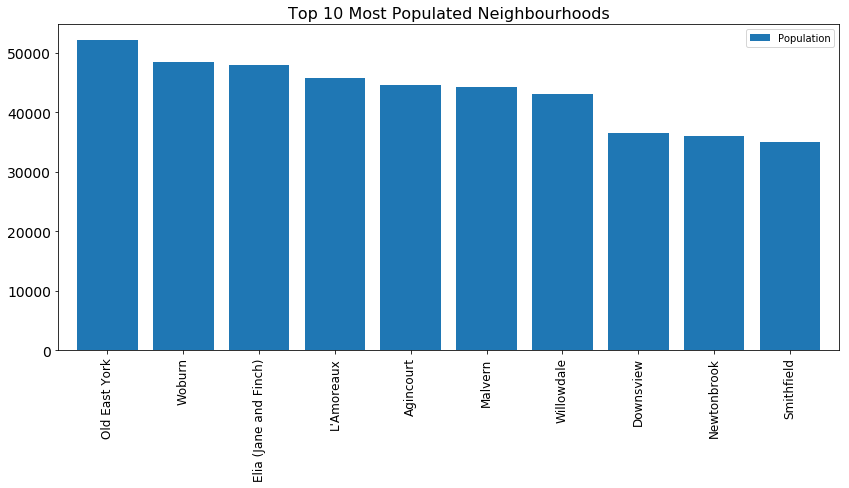

In [117]:
xlabels = ten_df['Neighbourhood'][:10]
top_population = ten_df[['Population']][:10]

fig = plt.figure()
ax = fig.add_subplot()
ax = top_population.plot(kind='bar', figsize=(14, 6), legend=True, fontsize=14, width=0.8)
plt.title('Top 10 Most Populated Neighbourhoods', fontsize=16)
ax.set_xticklabels(xlabels, fontsize=12)
plt.show()

<div class="text-success">
   <h3 id="">Second Most Popular Language</h3>
</div>
<h5>Let us now obtain the count plot for Second Most Popular Language (after English) in different neighbourhoods of Toronto</h5>

In [118]:
vb = pd.DataFrame(dmt_df.groupby('Language').count())
vb.sort_values(by = 'Neighbourhood',ascending=False, inplace=True)
vb['Neighbourhood'][:10]

Language
Portuguese             23
Unspecified Chinese    20
Cantonese              16
Polish                 12
Tamil                  12
Filipino               11
Spanish                11
Italian                10
Russian                 9
Ukrainian               7
Name: Neighbourhood, dtype: int64

<div class="text-success">
   <h3 id="">Plot Top 10 Second Most Popular Language using Barchart</h3>
</div>

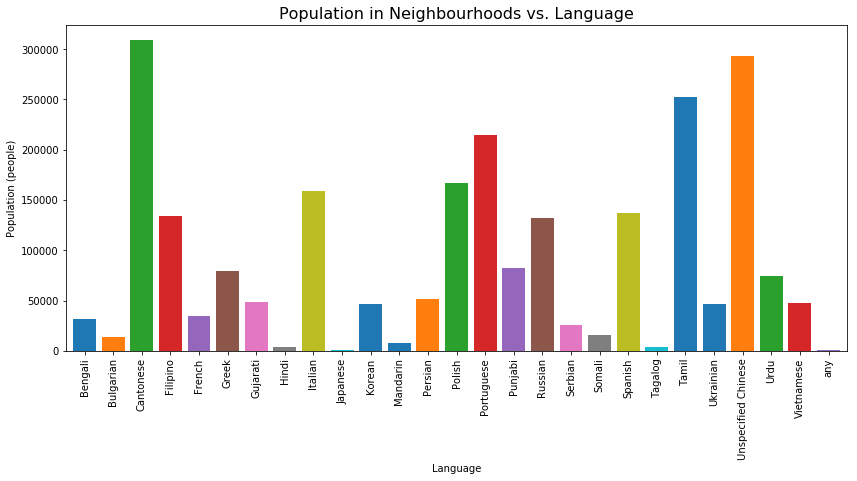

In [119]:
most_pop = dmt_df.groupby(['Language']).sum()
most_pop.plot(y='Population',kind='bar',figsize=(14,6),legend=False, width=0.8)

plt.title('Population in Neighbourhoods vs. Language', fontsize=16)
plt.xlabel('Language')
plt.ylabel('Population (people)')

plt.show()

<div class="text-success">
   <h3 id="">Barcode summirize following things</h3>
    <ol>
        <li>Cantonese is most popular language</li>
        <li>Tamil is most popular language out of all Indian language</li>
    </ol>
</div>

######                 

<div class="text-success">
   <h3 id="">Neighbourhoods with Indian Languages</h3>
</div>

In [120]:
ind_lang = [ 'Bengali','Gujarati', 'Hindi', 'Punjabi','Tamil']
lang = dmt_df[dmt_df['Language'].isin(ind_lang)]['Language']
lang.groupby(dmt_df['Language']).count()

Language
Bengali      3
Gujarati     1
Hindi        1
Punjabi      5
Tamil       12
Name: Language, dtype: int64

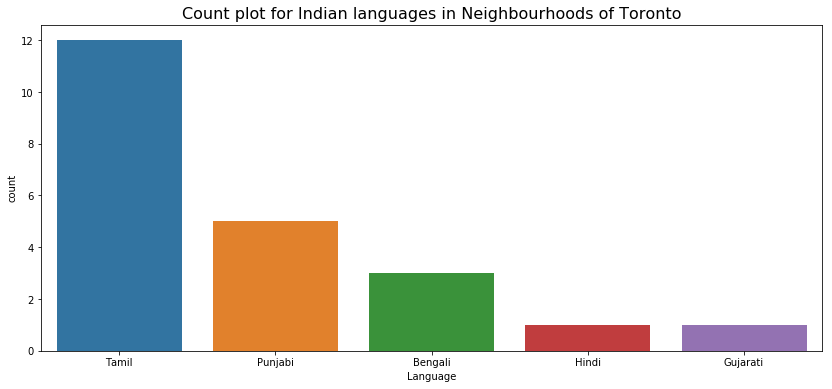

In [121]:
plt.figure(figsize = (14,6))
sns.countplot(x = lang, data=dmt_df)
plt.title('Count plot for Indian languages in Neighbourhoods of Toronto', fontsize=16)
plt.show()

<div class="text-success">
   <h3 id="">Create the dataframe containing only Indian Language Neighbourhoods</h3>
</div>

In [122]:
ind_df = dmt_df[dmt_df['Language'].isin(ind_lang)]
ind_df.reset_index(drop=True, inplace=True)
ind_df.sort_values('Density (people/km2)', ascending=False, inplace=True)
ind_df.head()

/home/angryleo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%)
3,Crescent Town,8157,20393,Bengali,18.1
13,Regent Park/Trefann Court,10387,16230,Bengali,10.5
12,Oakridge,13368,7187,Bengali,12.6
5,Eglinton East,22387,6931,Tamil,9.7
16,Scarborough City Centre,16403,6358,Tamil,10.3


<div class="text-success">
   <h3 id="">Plots for population of Toronto Neighbourhoods with different Indian Languages</h3>
</div>

In [123]:
ind_df.groupby(['Language']).sum()

,Population,Density (people/km2),Language Percentage(%)
Language,,,
Bengali,31912,43810,41.2
Gujarati,48507,3636,9.1
Hindi,3821,1794,1.7
Punjabi,82389,14741,68.8
Tamil,252036,46971,97.0


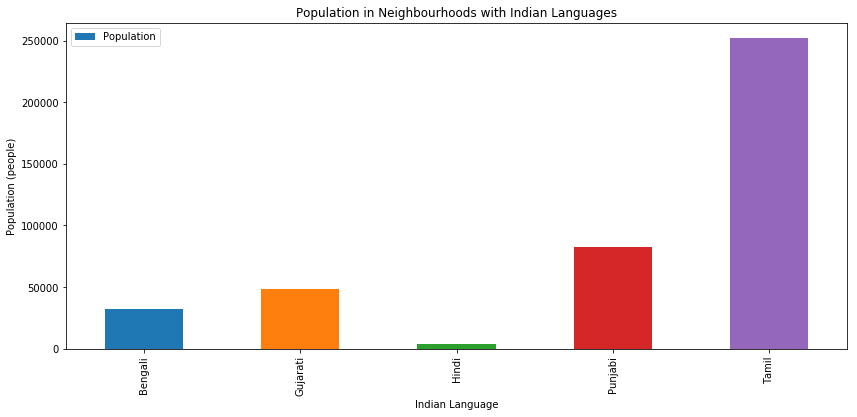

In [124]:
ind_df_plot = ind_df.groupby(['Language']).sum()

ind_df_plot.plot(y='Population',kind='bar',figsize=(14,6))
plt.xlabel('Indian Language')
plt.ylabel('Population (people)')
plt.title('Population in Neighbourhoods with Indian Languages')
plt.show()

<div class="text-info">
   <h5 id="">From the above plot, it is evident that the population of Tamil speaking people is the highest, followed by Punjabis and Bengalis. (among neighbourhoods with Indian languages)</h5>
</div>

<div class="text-success">
    <h4>Plot for population density of Toronto Neighbourhoods with different Indian Languages</h4>
</div>

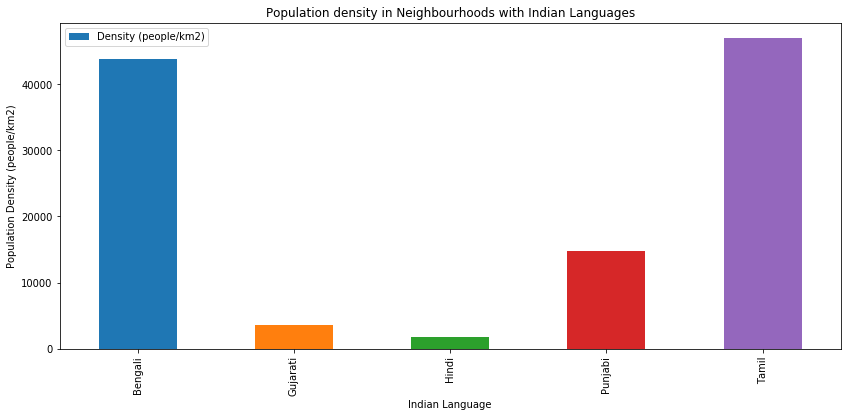

In [125]:
ind_df.groupby(['Language']).sum().plot(y='Density (people/km2)',kind='bar',figsize=(14,6))
plt.xlabel('Indian Language')
plt.ylabel('Population Density (people/km2)')
plt.title('Population density in Neighbourhoods with Indian Languages')
plt.show()

<div class="text-info">
   <h5 id="">From the above plot, it appears that Bengali Neighbourhoods are densely populated, followed by Tamil and Punjabi Neighbourhoods</h5>
</div>

<div class="text-success">
   <h3 id="">Scrape and Extract the required information from the webpage</h3>
    https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
</div>

In [126]:
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

In [127]:
toronto_pc= soup.find('table')                                #find the tablular column containing the required information
toronto_pc = toronto_pc.find('tbody')

toronto_pclist =[]                                            #create an empty list to store the extracted data

rows = toronto_pc.find_all('tr')                              #find all the rows in the table
for row in rows:
    cols = row.find_all('td')
    cols = [entry.text.strip() for entry in cols]             #extract the required text corresponding to each column
    toronto_pclist.append([entry for entry in cols if entry]) #append the data to the list

col_name = toronto_pc.find_all('th')                          #extract the column names
toronto_pclist[0] = [col.text.strip() for col in col_name]    #column names for the final dataframe


<div class="text-success"> 
    <h3> Required Dataframe</h3>
</div>

In [128]:
toronto_df = pd.DataFrame(toronto_pclist)   #convert the list to a dataframe
toronto_df.columns = toronto_df.iloc[0]     #name the columns
toronto_df.drop(0, inplace=True)            #drop the first row with column names
toronto_df.head()

,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


<div class="text-success"> 
    <h3>Basic Information about the Dataframe</h3>
</div>

In [129]:
toronto_df.shape

(289, 3)

In [130]:
toronto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 1 to 289
Data columns (total 3 columns):
Postcode         289 non-null object
Borough          289 non-null object
Neighbourhood    289 non-null object
dtypes: object(3)
memory usage: 9.0+ KB


<div class="text-success"> 
    <h3>Cleaning Stage</h3>
</div>

<div class="text-success"> 
    <h4>Replace the 'Not assigned' neighbourhoods with the name of the corresponding Borough</h4>
</div>

In [131]:
#assign the corresponding Borough Name for 'not assigned neighbourhoods'
toronto_df.loc[toronto_df['Neighbourhood'].eq('Not assigned'),'Neighbourhood'] = toronto_df.loc[toronto_df['Neighbourhood'].eq('Not assigned'),'Borough']
toronto_df.head()


,Postcode,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,Harbourfront


#### Drop all the rows with 'not assigned' neighbourhoods

In [132]:
toronto_df = toronto_df[toronto_df['Neighbourhood']!='Not assigned']  
toronto_df.reset_index(drop=True, inplace=True)
toronto_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


#### Check the number of rows in the resulting frame

In [133]:
print('Number of rows in the dataframe after cleaning: ',toronto_df.shape[0])

Number of rows in the dataframe after cleaning:  212


<div class="text-success">
    <h3>Merge the two dataframes (toronto_df, ind_df)</h3>
</div>

In [134]:
new_df3 = pd.merge(toronto_df, ind_df,  left_on='Neighbourhood', right_on='Neighbourhood')
print('Number of rows in the merged dataframe: ', new_df3.shape[0])

Number of rows in the merged dataframe:  11


In [135]:
new_df3.head()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%)
0,M1B,Scarborough,Rouge,22724,791,Tamil,15.6
1,M1B,Scarborough,Malvern,44324,5003,Tamil,12.2
2,M1C,Scarborough,Highland Creek,12853,2505,Tamil,5.1
3,M1E,Scarborough,Morningside,11472,4112,Tamil,10.8
4,M1E,Scarborough,West Hill,25632,2676,Tamil,3.0


In [136]:
new_df3.groupby('Language').count()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language Percentage(%)
Language,,,,,,
Bengali,1,1,1,1,1,1
Gujarati,1,1,1,1,1,1
Punjabi,1,1,1,1,1,1
Tamil,8,8,8,8,8,8


<div class="text-info">
    <h5>Dataframe with geospatial coordinates for all the Neighbourhoods</h5>
</div>

<div class="text-success">
    <h4>Get dataframe with geospatial coordinates from </h4>
    https://cocl.us/Geospatial_data
</div>

In [137]:
geo_coord = pd.read_csv('Geospatial_Coordinates.csv')
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [138]:
geo_coord.shape

(103, 3)

<div class="text-success">
    <h3>Merge the dataframes (new_df3 and geo_coord) to include Latitude and Longitude columns</h3>
</div>

In [139]:
toronto_df = pd.merge(new_df3, geo_coord, how='inner', left_on='Postcode', right_on = 'Postal Code')
toronto_df.drop('Postal Code', axis =1, inplace = True)
toronto_df.head(10)

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%),Latitude,Longitude
0,M1B,Scarborough,Rouge,22724,791,Tamil,15.6,43.806686,-79.194353
1,M1B,Scarborough,Malvern,44324,5003,Tamil,12.2,43.806686,-79.194353
2,M1C,Scarborough,Highland Creek,12853,2505,Tamil,5.1,43.784535,-79.160497
3,M1E,Scarborough,Morningside,11472,4112,Tamil,10.8,43.763573,-79.188711
4,M1E,Scarborough,West Hill,25632,2676,Tamil,3.0,43.763573,-79.188711
5,M1G,Scarborough,Woburn,48507,3636,Gujarati,9.1,43.770992,-79.216917
6,M1J,Scarborough,Scarborough Village,12796,6303,Tamil,11.4,43.744734,-79.239476
7,M1L,Scarborough,Oakridge,13368,7187,Bengali,12.6,43.711112,-79.284577
8,M1M,Scarborough,Cliffcrest,14531,2073,Tamil,1.5,43.716316,-79.239476
9,M1P,Scarborough,Dorset Park,14189,3331,Tamil,9.5,43.757410,-79.273304


In [140]:
toronto_df.shape

(11, 9)

In [142]:
ind_df = toronto_df[toronto_df['Language'].isin(ind_lang)]
ind_df.reset_index(drop=True, inplace=True)
ind_df.sort_values(by = 'Density (people/km2)', ascending=False, inplace=True)
ind_df.head()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%),Latitude,Longitude
7,M1L,Scarborough,Oakridge,13368,7187,Bengali,12.6,43.711112,-79.284577
6,M1J,Scarborough,Scarborough Village,12796,6303,Tamil,11.4,43.744734,-79.239476
1,M1B,Scarborough,Malvern,44324,5003,Tamil,12.2,43.806686,-79.194353
10,M9V,Etobicoke,Thistletown,16790,4229,Punjabi,8.6,43.739416,-79.588437
3,M1E,Scarborough,Morningside,11472,4112,Tamil,10.8,43.763573,-79.188711


<div class="text-success">
    <h2>Step 3: Segmenting and Clustering the neighbourhoods in Downtown Toronto</h2>
</div>

In [143]:
address = 'Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

/home/angryleo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [144]:
map_toronto = folium.Map(location = [latitude, longitude], zoom_start=10)

for lat, lng, neighbourhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

<div class="text-success">
    <h2>Foursquare credentials and version</h2>
</div>

In [149]:
CLIENT_ID = '542EBQ0BI4DQNRPN2C15P5Y2O4FGLRFHBE1QNJJRVPSBVXCU' # your Foursquare ID
CLIENT_SECRET = 'O5PZHMPAJBVFXFZYFZPSRZCRTLAANVGZXONZTOMD0TKTXDEZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 542EBQ0BI4DQNRPN2C15P5Y2O4FGLRFHBE1QNJJRVPSBVXCU
CLIENT_SECRET:O5PZHMPAJBVFXFZYFZPSRZCRTLAANVGZXONZTOMD0TKTXDEZ


In [150]:
LIMIT = 100
radius = 500

<div class="text-success">
    <h2>Explore the first neighbourhood (Parkwoods)</h2>
</div>

In [151]:
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge are 43.806686299999996, -79.19435340000001.


<div class="text-success">
    <h2>Get the top 100 venues that are in Parkwoods within a radius of 500 meters.</h2>
</div>

In [152]:
# GET request url
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=542EBQ0BI4DQNRPN2C15P5Y2O4FGLRFHBE1QNJJRVPSBVXCU&client_secret=O5PZHMPAJBVFXFZYFZPSRZCRTLAANVGZXONZTOMD0TKTXDEZ&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

In [153]:
# send the GET request and examine the results
results = requests.get(url).json()
results['response']['groups'][0]['items']

[{'reasons': {'count': 0,
   'items': [{'reasonName': 'globalInteractionReason',
     'summary': 'This spot is popular',
     'type': 'general'}]},
  'referralId': 'e-0-4bb6b9446edc76b0d771311c-0',
  'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
      'suffix': '.png'},
     'id': '4bf58dd8d48988d16e941735',
     'name': 'Fast Food Restaurant',
     'pluralName': 'Fast Food Restaurants',
     'primary': True,
     'shortName': 'Fast Food'}],
   'id': '4bb6b9446edc76b0d771311c',
   'location': {'cc': 'CA',
    'city': 'Toronto',
    'country': 'Canada',
    'crossStreet': 'Morningside & Sheppard',
    'distance': 387,
    'formattedAddress': ['Toronto ON', 'Canada'],
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.80744841934756,
      'lng': -79.19905558052072}],
    'lat': 43.80744841934756,
    'lng': -79.19905558052072,
    'state': 'ON'},
   'name': "Wendy's",
   'photos': {'count': 0, 'groups': []}}},
 {'reasons':

In [154]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Explore venues in the first neighbourhood (Parkwoods)

In [155]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056
1,Interprovincial Group,Print Shop,43.805630,-79.200378


In [156]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


<div class="text-success">
    <h2>Explore and get nearby venues for all the neighbourhoods in Toronto</h2>
</div>

In [157]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [158]:
# venues for the neighbourhoods in Toronto

toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )



Rouge
Malvern
Highland Creek
Morningside
West Hill
Woburn
Scarborough Village
Oakridge
Cliffcrest
Dorset Park
Thistletown


In [159]:
print(toronto_venues.shape)
toronto_venues.head()

(53, 7)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rouge,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,Rouge,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
3,Malvern,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
4,Highland Creek,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar


<div class="text-success">
    <h2>Number of venues in each neighbourhood</h2>
</div>

In [160]:
toronto_venues.groupby('Neighbourhood').count() #.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Cliffcrest,2,2,2,2,2,2
Dorset Park,7,7,7,7,7,7
Highland Creek,3,3,3,3,3,3
Malvern,2,2,2,2,2,2
Morningside,6,6,6,6,6,6
Oakridge,10,10,10,10,10,10
Rouge,2,2,2,2,2,2
Scarborough Village,2,2,2,2,2,2
Thistletown,9,9,9,9,9,9


In [161]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 36 unique categories.


<div class="text-success">
    <h2>Analyze each neighbourhood</h2>
</div>

In [162]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(53, 37)


,Neighbourhood,American Restaurant,Bakery,Bar,Beer Store,Breakfast Spot,Brewery,Bus Line,Bus Station,Chinese Restaurant,Coffee Shop,Convenience Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,History Museum,Indian Restaurant,Insurance Office,Intersection,Korean Restaurant,Latin American Restaurant,Medical Center,Metro Station,Mexican Restaurant,Motel,Moving Target,Park,Pet Store,Pharmacy,Pizza Place,Playground,Print Shop,Rental Car Location,Sandwich Place,Soccer Field,Vietnamese Restaurant
0,Rouge,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rouge,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Malvern,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Malvern,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,Highland Creek,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Group neighbourhoods and take the mean of the frequency of occurence of each venue

In [163]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,American Restaurant,Bakery,Bar,Beer Store,Breakfast Spot,Brewery,Bus Line,Bus Station,Chinese Restaurant,Coffee Shop,Convenience Store,Electronics Store,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,History Museum,Indian Restaurant,Insurance Office,Intersection,Korean Restaurant,Latin American Restaurant,Medical Center,Metro Station,Mexican Restaurant,Motel,Moving Target,Park,Pet Store,Pharmacy,Pizza Place,Playground,Print Shop,Rental Car Location,Sandwich Place,Soccer Field,Vietnamese Restaurant
0,Cliffcrest,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
1,Dorset Park,0.0,0.0,0.000000,0.0,0.000000,0.142857,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.285714,0.0,0.0,0.0,0.142857,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.142857,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.142857
2,Highland Creek,0.0,0.0,0.333333,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
3,Malvern,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.5,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.5,0.000000,0.0,0.0,0.000000
4,Morningside,0.0,0.0,0.000000,0.0,0.166667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.166667,0.0,0.166667,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.0,0.0,0.166667,0.0,0.0,0.000000


In [164]:
toronto_grouped.shape

(11, 37)

<div class="text-success">
    <h2>Top 5 most frequent venues in each neighbourhood</h2>
</div>

In [165]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cliffcrest----
                       venue  freq
0        American Restaurant   0.5
1                      Motel   0.5
2                     Bakery   0.0
3  Latin American Restaurant   0.0
4             Medical Center   0.0


----Dorset Park----
                   venue  freq
0      Indian Restaurant  0.29
1  Vietnamese Restaurant  0.14
2              Pet Store  0.14
3                Brewery  0.14
4     Chinese Restaurant  0.14


----Highland Creek----
                 venue  freq
0                  Bar  0.33
1       History Museum  0.33
2        Moving Target  0.33
3  American Restaurant  0.00
4            Pet Store  0.00


----Malvern----
                  venue  freq
0            Print Shop   0.5
1  Fast Food Restaurant   0.5
2   American Restaurant   0.0
3                  Park   0.0
4        Medical Center   0.0


----Morningside----
                 venue  freq
0    Electronics Store  0.17
1       Medical Center  0.17
2       Breakfast Spot  0.17
3  Rental Car Location  0.17

<div class="text-success">
    <h2>Create a dataframe listing the top 10 most frequent venues for each neighbourhood</h2>
</div>

In [166]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [167]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cliffcrest,American Restaurant,Motel,Indian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Convenience Store,Coffee Shop,Chinese Restaurant
1,Dorset Park,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Brewery,Pet Store,Chinese Restaurant,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant
2,Highland Creek,History Museum,Moving Target,Bar,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Convenience Store,Coffee Shop,Vietnamese Restaurant
3,Malvern,Print Shop,Fast Food Restaurant,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Electronics Store,Convenience Store,Coffee Shop,Bus Station
4,Morningside,Mexican Restaurant,Rental Car Location,Electronics Store,Pizza Place,Breakfast Spot,Medical Center,Vietnamese Restaurant,Fried Chicken Joint,Fast Food Restaurant,Convenience Store


<div class="text-success">
    <h2>Perform clustering using k-means</h2>
</div>

<div class="text-success">
    <h4>Find the optimum k value</h4>
</div>

In [168]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

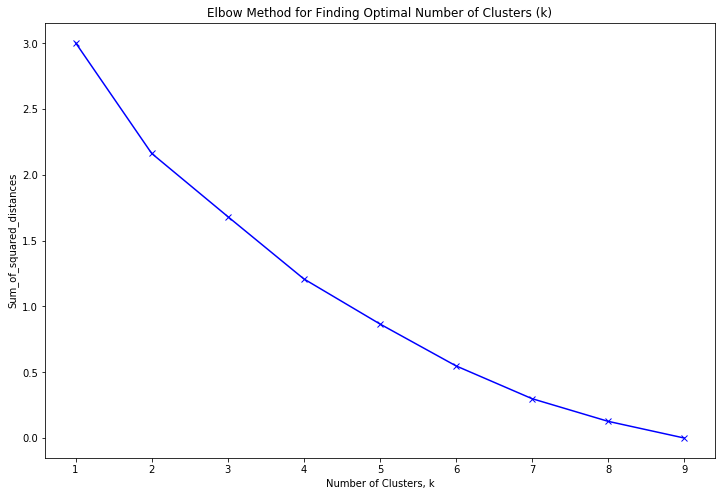

In [169]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.figure(figsize=(12,8))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Finding Optimal Number of Clusters (k)')
plt.show()

<div class="text-success">
    <h2>From the above plot, we can say that the optimal k value is 5.</h2>
</div>

In [170]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 0, 0, 1, 0, 0, 1, 3, 0, 0, 4], dtype=int32)

<div class="text-success">
    <h2>Dataframe with cluster number and top 10 venues for each neighbourhood</h2>
</div>

In [171]:
# add clustering labels
toronto_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,Postcode,Borough,Neighbourhood,Population,Density (people/km2),Language,Language Percentage(%),Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,Rouge,22724,791,Tamil,15.6,43.806686,-79.194353,1,Print Shop,Fast Food Restaurant,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Electronics Store,Convenience Store,Coffee Shop,Bus Station
1,M1B,Scarborough,Malvern,44324,5003,Tamil,12.2,43.806686,-79.194353,1,Print Shop,Fast Food Restaurant,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Electronics Store,Convenience Store,Coffee Shop,Bus Station
2,M1C,Scarborough,Highland Creek,12853,2505,Tamil,5.1,43.784535,-79.160497,0,History Museum,Moving Target,Bar,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Convenience Store,Coffee Shop,Vietnamese Restaurant
3,M1E,Scarborough,Morningside,11472,4112,Tamil,10.8,43.763573,-79.188711,0,Mexican Restaurant,Rental Car Location,Electronics Store,Pizza Place,Breakfast Spot,Medical Center,Vietnamese Restaurant,Fried Chicken Joint,Fast Food Restaurant,Convenience Store
4,M1E,Scarborough,West Hill,25632,2676,Tamil,3.0,43.763573,-79.188711,0,Mexican Restaurant,Rental Car Location,Electronics Store,Pizza Place,Breakfast Spot,Medical Center,Vietnamese Restaurant,Fried Chicken Joint,Fast Food Restaurant,Convenience Store


In [172]:
toronto_merged.dropna(how ='any', inplace = True)

In [173]:
toronto_merged['Cluster Labels'].unique()

array([1, 0, 4, 3, 2])

In [174]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)

In [175]:
toronto_merged.columns

Index(['Postcode', 'Borough', 'Neighbourhood', 'Population',
       'Density (people/km2)', 'Language', 'Language Percentage(%)',
       'Latitude', 'Longitude', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

<div class="text-success">
    <h2>Map showing the clusters</h2>
</div>

In [176]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<div class="text-success">
    <h4> Examine the clusters</h4>
</div>


In [177]:
toronto_merged.columns[[1,2,3,4,5] + list(range(9,toronto_merged.shape[1]))] #range()]

Index(['Borough', 'Neighbourhood', 'Population', 'Density (people/km2)',
       'Language', 'Cluster Labels', '1st Most Common Venue',
       '2nd Most Common Venue', '3rd Most Common Venue',
       '4th Most Common Venue', '5th Most Common Venue',
       '6th Most Common Venue', '7th Most Common Venue',
       '8th Most Common Venue', '9th Most Common Venue',
       '10th Most Common Venue'],
      dtype='object')

In [178]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [179]:
cluster_0.shape

(6, 16)

In [180]:
#cluster_0.groupby('Language Percentage').count()
cluster_0.groupby(['Language', 'Neighbourhood','Borough','1st Most Common Venue', '2nd Most Common Venue', '3rd Most Common Venue']).count()

Population  \
Language Neighbourhood  Borough     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue                   
Bengali  Oakridge       Scarborough Bakery                Bus Line              Soccer Field                        1   
Punjabi  Thistletown    Etobicoke   Grocery Store         Sandwich Place        Fried Chicken Joint                 1   
Tamil    Dorset Park    Scarborough Indian Restaurant     Vietnamese Restaurant Latin American Restaurant           1   
         Highland Creek Scarborough History Museum        Moving Target         Bar                                 1   
         Morningside    Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                   1   
         West Hill      Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                   1   

                                                                                                           Density (people/km2)  \
Language Neighbourhood  Borough     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue                             
Bengali  Oakridge       Scarborough Bakery                Bus Line              Soccer Field                                  1   
Punjabi  Thistletown    Etobicoke   Grocery Store         Sandwich Place        Fried Chicken Joint                           1   
Tamil    Dorset Park    Scarborough Indian Restaurant     Vietnamese Restaurant Latin American Restaurant                     1   
         Highland Creek Scarborough History Museum        Moving Target         Bar                                           1   
         Morningside    Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                             1   
         West Hill      Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                             1   

                                                                                                           Cluster Labels  \
Language Neighbourhood  Borough     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue                       
Bengali  Oakridge       Scarborough Bakery                Bus Line              Soccer Field                            1   
Punjabi  Thistletown    Etobicoke   Grocery Store         Sandwich Place        Fried Chicken Joint                     1   
Tamil    Dorset Park    Scarborough Indian Restaurant     Vietnamese Restaurant Latin American Restaurant               1   
         Highland Creek Scarborough History Museum        Moving Target         Bar                                     1   
         Morningside    Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                       1   
         West Hill      Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                       1   

                                                                                                           4th Most Common Venue  \
Language Neighbourhood  Borough     1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue                              
Bengali  Oakridge       Scarborough Bakery                Bus Line              Soccer Field                                   1   
Punjabi  Thistletown    Etobicoke   Grocery Store         Sandwich Place        Fried Chicken Joint                            1   
Tamil    Dorset Park    Scarborough Indian Restaurant     Vietnamese Restaurant Latin American Restaurant                      1   
         Highland Creek Scarborough History Museum        Moving Target         Bar                                            1   
         Morningside    Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                              1   
         West Hill      Scarborough Mexican Restaurant    Rental Car Location   Electronics Store                              1   

                               

#### Examine the neighbourhoods with Indian Languages

In [181]:
cluster_0[cluster_0['Language']=='Tamil']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,Highland Creek,12853,2505,Tamil,0,History Museum,Moving Target,Bar,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Convenience Store,Coffee Shop,Vietnamese Restaurant
3,Scarborough,Morningside,11472,4112,Tamil,0,Mexican Restaurant,Rental Car Location,Electronics Store,Pizza Place,Breakfast Spot,Medical Center,Vietnamese Restaurant,Fried Chicken Joint,Fast Food Restaurant,Convenience Store
4,Scarborough,West Hill,25632,2676,Tamil,0,Mexican Restaurant,Rental Car Location,Electronics Store,Pizza Place,Breakfast Spot,Medical Center,Vietnamese Restaurant,Fried Chicken Joint,Fast Food Restaurant,Convenience Store
9,Scarborough,Dorset Park,14189,3331,Tamil,0,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Brewery,Pet Store,Chinese Restaurant,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant


In [182]:
cluster_0[cluster_0['Language']=='Bengali']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Scarborough,Oakridge,13368,7187,Bengali,0,Bakery,Bus Line,Soccer Field,Intersection,Fast Food Restaurant,Bus Station,Park,Metro Station,Vietnamese Restaurant,Convenience Store


In [183]:
cluster_0[cluster_0['Language']=='Punjabi']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Etobicoke,Thistletown,16790,4229,Punjabi,0,Grocery Store,Sandwich Place,Fried Chicken Joint,Fast Food Restaurant,Beer Store,Pizza Place,Pharmacy,Coffee Shop,Chinese Restaurant,Electronics Store


In [184]:
cluster_0[cluster_0['Language']=='Gujarati']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [185]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [186]:
cluster_1.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,Rouge,22724,791,Tamil,1,Print Shop,Fast Food Restaurant,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Electronics Store,Convenience Store,Coffee Shop,Bus Station
1,Scarborough,Malvern,44324,5003,Tamil,1,Print Shop,Fast Food Restaurant,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Electronics Store,Convenience Store,Coffee Shop,Bus Station


In [187]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [188]:
cluster_2.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Scarborough,Cliffcrest,14531,2073,Tamil,2,American Restaurant,Motel,Indian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Convenience Store,Coffee Shop,Chinese Restaurant


In [189]:
cluster_3 =toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [190]:
cluster_3.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,Scarborough Village,12796,6303,Tamil,3,Playground,Convenience Store,Vietnamese Restaurant,Chinese Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Coffee Shop,Bus Station


In [191]:
cluster_4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1,2,3,4,5] + list(range(9, toronto_merged.shape[1]))]]

In [192]:
cluster_4.head()

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Scarborough,Woburn,48507,3636,Gujarati,4,Coffee Shop,Insurance Office,Korean Restaurant,Indian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Convenience Store,Chinese Restaurant


<div class="text-info">
    <h5>From the above result, we can observe that 'Dorset Park' neighbourhood includes relatively more number of restaurants.  The business statement requires a location with restaurants in the vicinity. So this neighbourhood can be considered for opening our new business unit.</h5>
</div>

<div class="text-success">
    <h3>Results corresponding to 'Dorset Park' Neighbourhood</h3>
</div>

In [193]:
cluster_0[cluster_0['Neighbourhood']=='Dorset Park']

,Borough,Neighbourhood,Population,Density (people/km2),Language,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Scarborough,Dorset Park,14189,3331,Tamil,0,Indian Restaurant,Vietnamese Restaurant,Latin American Restaurant,Brewery,Pet Store,Chinese Restaurant,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant
